# Add a user defined model

- energy dependent spatial model
- gaussian with sigma(E)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.coordinates.angle_utilities import angular_separation, position_angle
from regions import CircleSkyRegion, RectangleSkyRegion
from gammapy.data import DataStore
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import (
    MapDatasetMaker,  
    SafeMaskMaker, 
    FoVBackgroundMaker
)
from gammapy.datasets import MapDataset
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModelBase
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.modeling import Parameter, Parameters, Fit


In [6]:
class EneDepGaussian(SkyModelBase):
    
    tag = "EneDepGaussian"
    lon_0 = Parameter("lon_0", "0 deg")
    lat_0 = Parameter("lat_0", "0 deg", min=-90, max=90)
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1")
    reference = Parameter("reference", "1 TeV", frozen=True)
    alpha = Parameter("alpha", 1.0) #index for gaussian width
    index = Parameter("index", 2.0) #spectral index
    
    _apply_irf_default = {"exposure": True, "psf": True, "edisp": True}
    
    def sigma(self, energy):
        return np.power(energy/self.reference.quantity, -self.alpha.value)
    
    def evaluation_radius(self, sigma):
        return 5 * sigma
    
    def evaluate_geom(self, geom, gti=None):
        coords = geom.get_coord(frame=geom.frame)
        return self(coords.lon, coords.lat, coords["energy_true"])
    
    def evaluate(self, lon, lat, energy, time=None):
        """Evaluate model"""
        sep = angular_separation(lon, lat, self.lon_0.quantity, self.lat_0.quantity)
        sigma = self.sigma(energy)
        exponent =  (-0.5 * (sep / sigma) ** 2.0).value
        spec = self.amplitude.quantity * np.power((energy / self.reference.quantity), -self.index.value)
        return spec*np.exp(exponent)
            
        

In [48]:
model = EneDepGaussian(index=2, alpha=2)

In [49]:
model.lon_0

Parameter(name='lon_0', value=0.0, factor=0.0, scale=1.0, unit=Unit("deg"), min=nan, max=nan, frozen=False, id=0x11cae7b70)

In [50]:
model.index

Parameter(name='index', value=2.0, factor=2.0, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=False, id=0x11d59e390)

In [51]:
model.sigma(energy_axis.edges)

<Quantity [1.        , 0.30170882, 0.09102821, 0.02746401, 0.00828614,
           0.0025    ]>

In [52]:
coords = geom.get_coord(frame=geom.frame)

In [53]:
model1 = model.evaluate_geom(geom)

In [20]:
npred = Map.from_geom(geom=geom, data=model1.data)

In [21]:
npred.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [340]:
class EneDepAsyGaussian(SkyModelBase):
    

    tag = "Gaussian3DModel"

    lon_0 = Parameter("lon_0", "0 deg")
    lat_0 = Parameter("lat_0", "0 deg", min=-90, max=90)
    ellip = Parameter("e", 0, min=0, max=1, frozen=True)
    phi = Parameter("phi", "0 deg", frozen=True)
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0) # diff flux at reference
    norm_sigma = Parameter("norm_sigma", "1 deg", min=0) #semi-major axis at reference
    reference = Parameter("reference", "1 TeV", frozen=True) #reference energy
    alpha = Parameter("alpha", 1.0) #index for gaussian width
    delta = Parameter("delta", 0.0) #index for ellipticy variation
    index = Parameter("index", 2.0) #spectral index

    
    def __init__(self, **kwargs):
        frame = kwargs.pop("frame", "galactic")
        super().__init__(**kwargs)
        if not hasattr(self, "frame"):
            self.frame = frame
            

    def sigma_major(self, energy):
        s_maj = self.norm_sigma * np.power(energy/self.reference.quantity, -self.alpha.value)
        return Angle(s_maj)
    
 
    def sigma_minor(self, energy):
        s_maj = self.sigma_major(energy)
        e = self.ellip * np.power(energy/self.reference.quantity, -self.delta.value)
        s_min = Angle(s_maj * np.sqrt(1 - e ** 2))
        return s_min 
    
   
    def sigma_eff(self, lon, lat, energy):
        s_maj = self.sigma_major(energy)
        s_min = self.sigma_minor(energy)    
        phi_0 = position_angle(self.lon_0.quantity, self.lat_0.quantity, lon, lat)
        d_phi = self.phi - phi_0
        a2 = np.power(s_maj*np.sin(d_phi), 2.0) 
        b2 = np.power(s_min*np.cos(d_phi), 2.0) 
        denominator = np.sqrt(a2 + b2)
        sigma_eff = s_maj * s_min / denominator
        return sigma_eff

    
    def evaluate(self, lon, lat, energy, time=None):
        """Evaluate model"""
        sep = angular_separation(lon, lat, self.lon_0.quantity, self.lat_0.quantity)
        sigma = self.sigma_eff(lon, lat, energy)
        exponent =  (-0.5 * (sep / sigma) ** 2.0).value
        spec = self.amplitude.quantity * np.power((energy / self.reference.quantity), -self.index.value)
        return spec*np.exp(exponent)
    
    def evaluate_geom(self, geom, gti=None):
        coords = geom.get_coord(frame=geom.frame)
        return self(coords.lon, coords.lat, coords["energy_true"])

In [341]:
elow = 1.0
ehigh = 20.0
pos = SkyCoord(20.0, 20.0, unit='deg', frame="icrs")
energy_axis = MapAxis.from_bounds(elow, ehigh, nbin=10, unit='TeV', interp='log', name="energy_true")
geom = WcsGeom.create(binsz=0.05, skydir=pos, width=6, frame="icrs",
    proj="CAR", axes=[energy_axis])


In [342]:
model = EneDepAsyGaussian(frame="icrs")
model.index.value = 2.0
model.alpha.value = 2.0
model.phi.value = 90.0
model.ellip.value = 0.9
model.lon_0.value = 20
model.lat_0.value = 20

In [343]:
model.parameters.to_table()

name,value,error,unit,min,max,frozen
str10,float64,int64,str14,float64,float64,bool
lon_0,2.000e+01,0.000e+00,deg,nan,nan,False
lat_0,2.000e+01,0.000e+00,deg,-9.000e+01,9.000e+01,False
e,9.000e-01,0.000e+00,,0.000e+00,1.000e+00,True
phi,9.000e+01,0.000e+00,deg,nan,nan,True
amplitude,1.000e-12,0.000e+00,cm-2 s-1 TeV-1,0.000e+00,nan,False
norm_sigma,1.000e+00,0.000e+00,deg,0.000e+00,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
alpha,2.000e+00,0.000e+00,,nan,nan,False
delta,0.000e+00,0.000e+00,,nan,nan,False


In [344]:
model.sigma_major(energy=energy_axis.edges)

<Angle [1.        , 0.54928027, 0.30170882, 0.1657227 , 0.09102821,
        0.05      , 0.02746401, 0.01508544, 0.00828614, 0.00455141,
        0.0025    ] deg>

In [345]:
model.frame

'icrs'

In [346]:
model.sigma_minor(energy=energy_axis.edges)

<Angle [0.43588989, 0.23942572, 0.13151182, 0.07223685, 0.03967828,
        0.02179449, 0.01197129, 0.00657559, 0.00361184, 0.00198391,
        0.00108972] deg>

In [347]:
model.sigma_eff(lon=0.5*u.deg, lat=1.0*u.deg, energy=energy_axis.edges)

<Quantity [0.58255381, 0.31998531, 0.17576162, 0.09654239, 0.05302883,
           0.02912769, 0.01599927, 0.00878808, 0.00482712, 0.00265144,
           0.00145638] deg>

In [348]:
model.sigma_eff(lon=1.0*u.deg, lat=0.5*u.deg, energy=energy_axis.edges)

<Quantity [0.57142672, 0.31387342, 0.17240448, 0.09469838, 0.05201595,
           0.02857134, 0.01569367, 0.00862022, 0.00473492, 0.0026008 ,
           0.00142857] deg>

In [349]:
model1 = model.evaluate_geom(geom)

In [350]:
npred = Map.from_geom(geom=geom, data=model1.data)

In [351]:
npred.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [292]:
from gammapy.modeling.models import GaussianSpatialModel

In [311]:
m = GaussianSpatialModel()
m.e.value = 0.9

In [312]:
m1 = m.evaluate_geom(geom=geom.to_image())

In [313]:
npred = Map.from_geom(geom=geom.to_image(), data=m1.data)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x128220c50>)

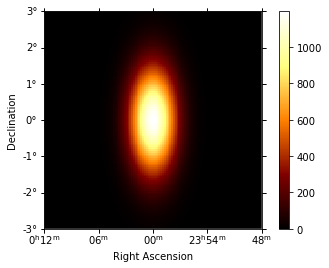

In [314]:
npred.plot(add_cbar=True)